In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


In [2]:
sample=pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv")
train=pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/train.csv")
label=train['Crime_Category'].copy()
test=pd.read_csv("/kaggle/input/crime-cast-forecasting-crime-categories/test.csv")

In [3]:
# Kernel Runtime Management
import sys
import warnings
if not sys.warnoptions:
    # To ignore warinings
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"


# Code Reproducibility
import random 
random.seed(42)
np.random.seed(42)

# ML/DL Libraries
from xgboost import XGBClassifier
import lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier # For Baseline Model

# Performance Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

# Visualization Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config, compose, pipeline
set_config(display='diagram')
%matplotlib inline


# Pre-processing/Feature Engineering 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import VarianceThreshold,SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures, RobustScaler,OrdinalEncoder,StandardScaler,LabelEncoder

# Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV 

# Pipeline
from sklearn.pipeline import Pipeline



In [4]:
print('Train Data Shape : \t', train.shape)
print('Test Data Shape : \t', test.shape)

Train Data Shape : 	 (20000, 22)
Test Data Shape : 	 (5000, 21)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,20000.0,33.940704,2.126810,0.0000,34.0092,34.0587,34.165025,34.3281
Longitude,20000.0,-117.893072,7.377726,-118.6634,-118.4297,-118.3230,-118.274400,0.0000
Time_Occurred,20000.0,1352.380350,646.100291,1.0000,930.0000,1430.0000,1900.000000,2359.0000
Area_ID,20000.0,10.834250,6.033166,1.0000,6.0000,11.0000,16.000000,21.0000
Reporting_District_no,20000.0,1129.599200,603.330519,101.0000,632.0000,1162.0000,1622.000000,2197.0000
Part 1-2,20000.0,1.418150,0.493267,1.0000,1.0000,1.0000,2.000000,2.0000
Victim_Age,20000.0,30.135000,21.863645,-2.0000,12.0000,31.0000,46.000000,99.0000
Premise_Code,20000.0,297.176950,212.007298,101.0000,101.0000,203.0000,501.000000,969.0000
Weapon_Used_Code,7335.0,366.405044,120.485687,101.0000,312.0000,400.0000,400.000000,515.0000


In [7]:
train.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


# *Exploratory Data Analysis (EDA)*

Text(0.5, 1.0, 'Crime Category vs Count')

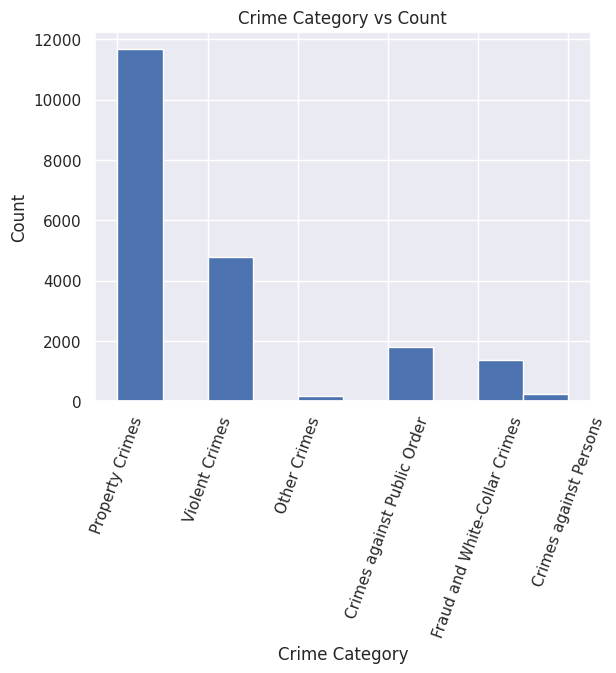

In [8]:
sns.set()
train.Crime_Category.hist()
plt.xlabel("Crime Category")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.title("Crime Category vs Count")

**Plot 1 Inference**
The graph indicates that *Property Crimes* are the most frequent, significantly outnumbering other categories, with *Violent Crimes* being the second most common. *Crimes against Persons* are the least frequent among the categories presented.

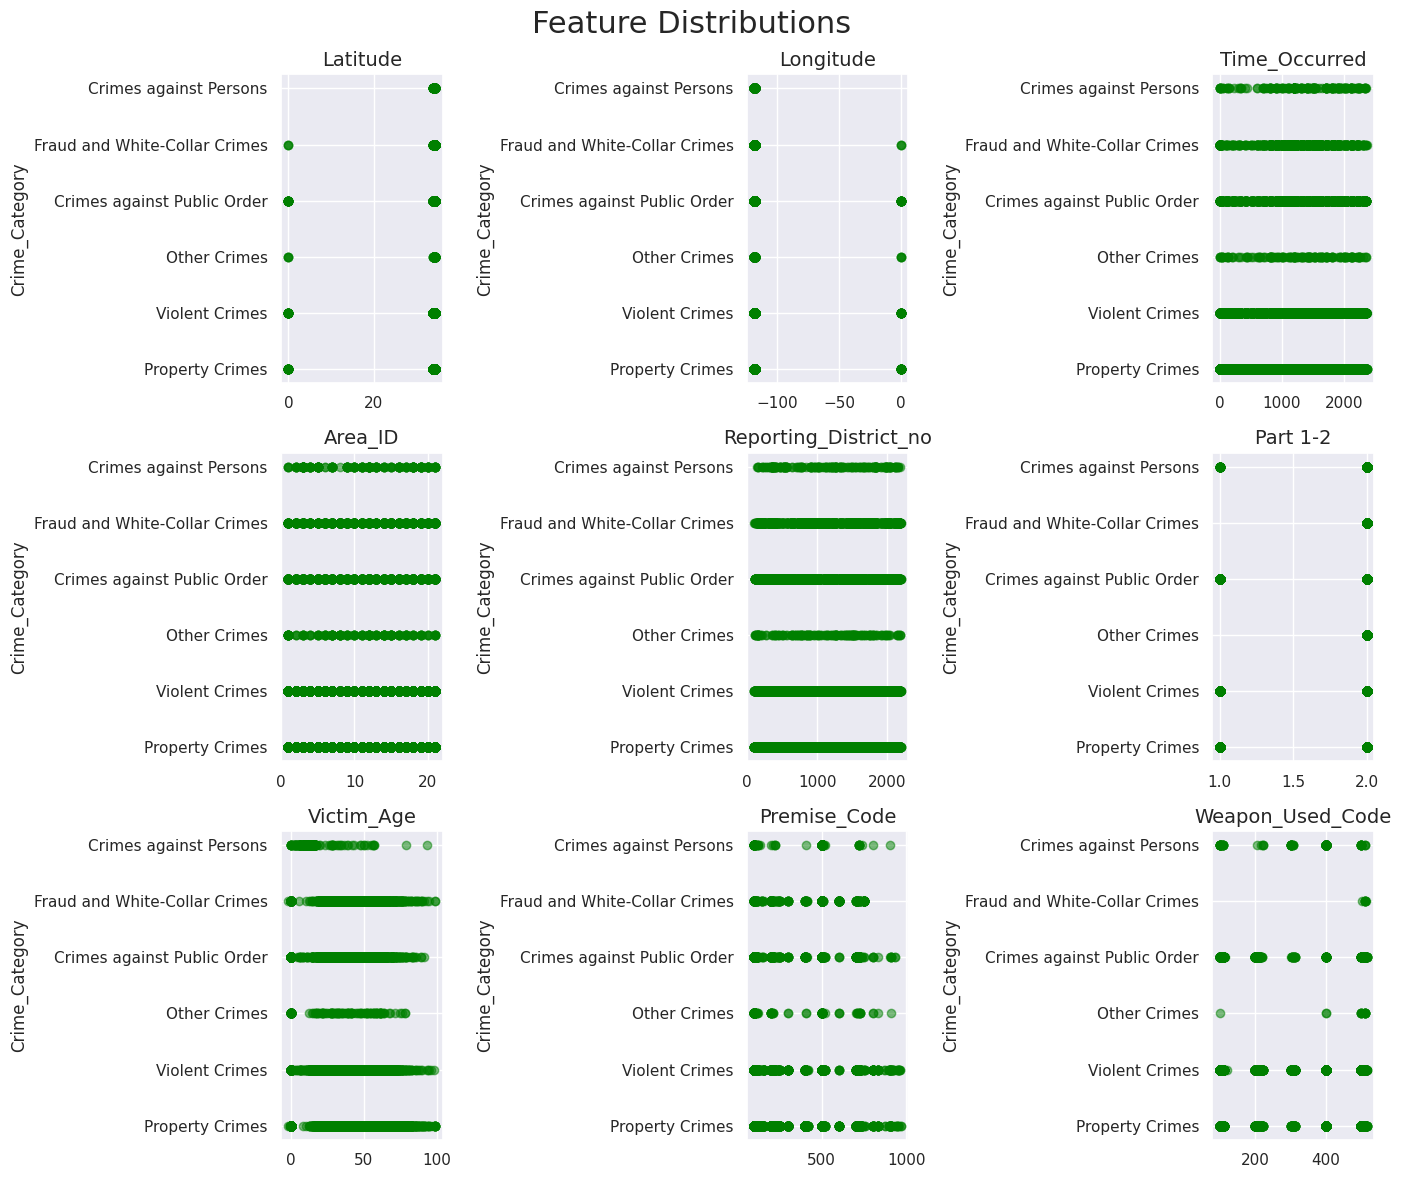

In [9]:
Data_In = train.drop(columns=['Location','Crime_Category','Status_Description','Status','Weapon_Description','Premise_Description','Cross_Street', 'Date_Reported', 'Date_Occurred', 'Area_Name', 'Modus_Operandi', 'Victim_Sex','Victim_Descent'])

num_features = len(Data_In.columns)

num_rows = (num_features + 2) // 3 


fig, axes = plt.subplots(num_rows, 3, figsize=(14, 4 * num_rows))
fig.suptitle('Feature Distributions', fontsize=22)

for i, feature in enumerate(Data_In.columns):
    row, col = divmod(i, 3)
    current_ax = axes[row, col]

    current_ax.scatter(Data_In[feature], train['Crime_Category'], c='green', alpha=0.5)
    current_ax.set_title(feature, fontsize=14)
    current_ax.set_xlabel(None)
    current_ax.set_ylabel("Crime_Category")

# Remove empty subplots
if num_features % 3 != 0:
    for j in range(num_features, num_rows * 3):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


**Plot 2 Inference**

**Latitude and Longitude**: There is a wide distribution of crimes across different geographical coordinates, with Property Crimes again appearing most frequently.

**Time_Occurred**: Crimes occur throughout different times, with some concentrations, but Property Crimes consistently remain the highest.

**Area_ID**: Crime distribution varies across different areas, with certain areas having higher concentrations of Property Crimes.

**Reporting_District_no**: There is a varied distribution across different reporting districts, with Property Crimes being prevalent.

**Part_1-2**: The majority of the crimes fall under the first part, with Property Crimes being the most common.

**Victim_Age**: Crimes occur across a wide age range, with Property Crimes consistently being the most reported.

**Premise_Code**: Different premises show varied distributions of crimes, with a noticeable higher frequency of Property Crimes.

**Weapon_Used_Code**: Various weapons are used across crime categories, but Property Crimes remain the highest.

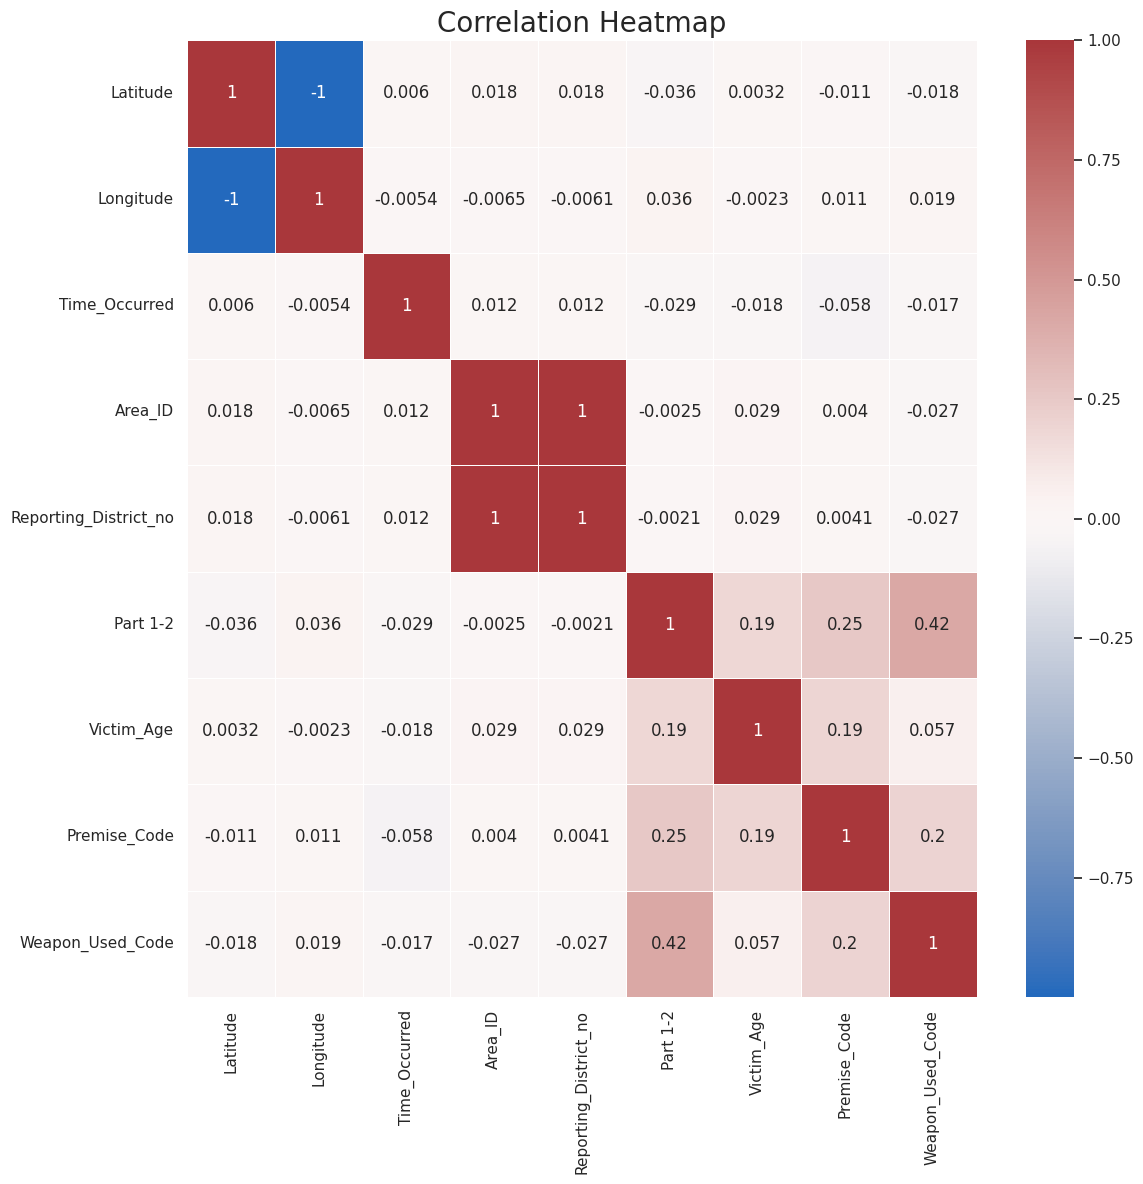

In [10]:
num_features = len(Data_In.columns)
correlation_matrix = Data_In.corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='vlag', linewidths=.5)
plt.title('Correlation Heatmap', fontsize=20)
plt.tight_layout()
plt.show()

**Plot 3 Inference**

**Latitude and Longitude**: There is a perfect negative correlation between Latitude and Longitude (-1), indicating they are inversely related.

**Time_Occurred**: Time_Occurred has very low correlation with other variables, indicating that the time a crime occurs does not have a strong linear relationship with the other features.

**Area_ID and Reporting_District_no**: These two features are perfectly correlated (1), suggesting they might be redundant or represent the same underlying information.

**Part_1-2**: There is a moderate positive correlation with Victim_Age (0.19), Premise_Code (0.25), and a strong positive correlation with Weapon_Used_Code (0.42). This suggests that more severe crimes (Part 1) are more likely to involve weapons and certain premises, and might be slightly related to the age of the victim.

**Victim_Age**: There is a low to moderate positive correlation with Premise_Code (0.19) and Weapon_Used_Code (0.057), indicating older victims might be associated with certain premises and possibly involve weapon use.

**Premise_Code**: There is a low positive correlation with Weapon_Used_Code (0.20), suggesting some premises might be more associated with crimes involving weapons.

**General Observations**:Most features have low or negligible correlations with each other, indicating that they are relatively independent in terms of linear relationships.
Strong correlations (close to 1 or -1) indicate direct or inverse relationships, whereas values close to 0 suggest no linear relationship.

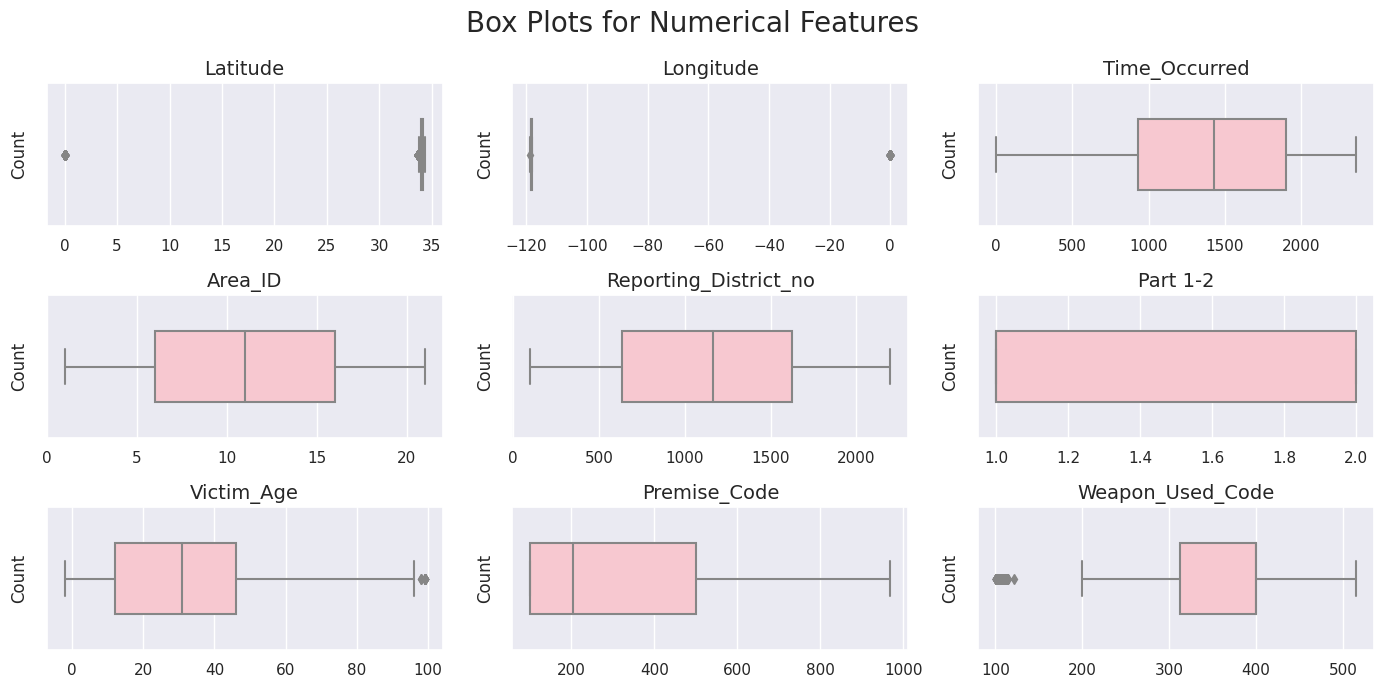

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(14, 7))
axes = axes.ravel()

for i, column in enumerate(Data_In):
    sns.boxplot(x=column, data=train, color='pink', width=0.5, fliersize=5, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Count', fontsize=12)
plt.suptitle('Box Plots for Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

**Plot 4 Inference**

**Latitude**:
The data points are tightly clustered around the mid-30s.
There is one significant outlier.

**Longitude**:
The data points are clustered around -118 to -120.
There are some outliers towards the right.

**Time_Occurred**:
The median time occurred is around the mid-point of the 24-hour period.
The data is quite spread out, with no significant outliers.

**Area_ID**:
The data is evenly distributed between Area_ID 5 and 15.
There are no significant outliers.

**Reporting_District_no**:
The median reporting district number is around 1200.
The data is spread evenly, with no significant outliers.

**Part 1-2**:
The data points are concentrated around the value of 1.
This indicates a categorical distribution with no spread.

**Victim_Age**:
The ages of victims are mostly between 20 and 50.
There are some significant outliers towards the right, with ages around 100.

**Premise_Code**:
The data is spread evenly with a median around 500.
There are no significant outliers.

**Weapon_Used_Code**:
The weapon codes are mostly centered around 300 to 400.
There are some outliers towards the left, around 100.

**General Observations**:
Outliers: Latitude, Longitude, Victim_Age, and Weapon_Used_Code have notable outliers.
**Uniform Distribution**: Features like Area_ID, Reporting_District_no, and Premise_Code show a relatively uniform distribution without significant outliers.
**Categorical Nature**: Part 1-2 seems to be categorical with most values concentrated around 1.

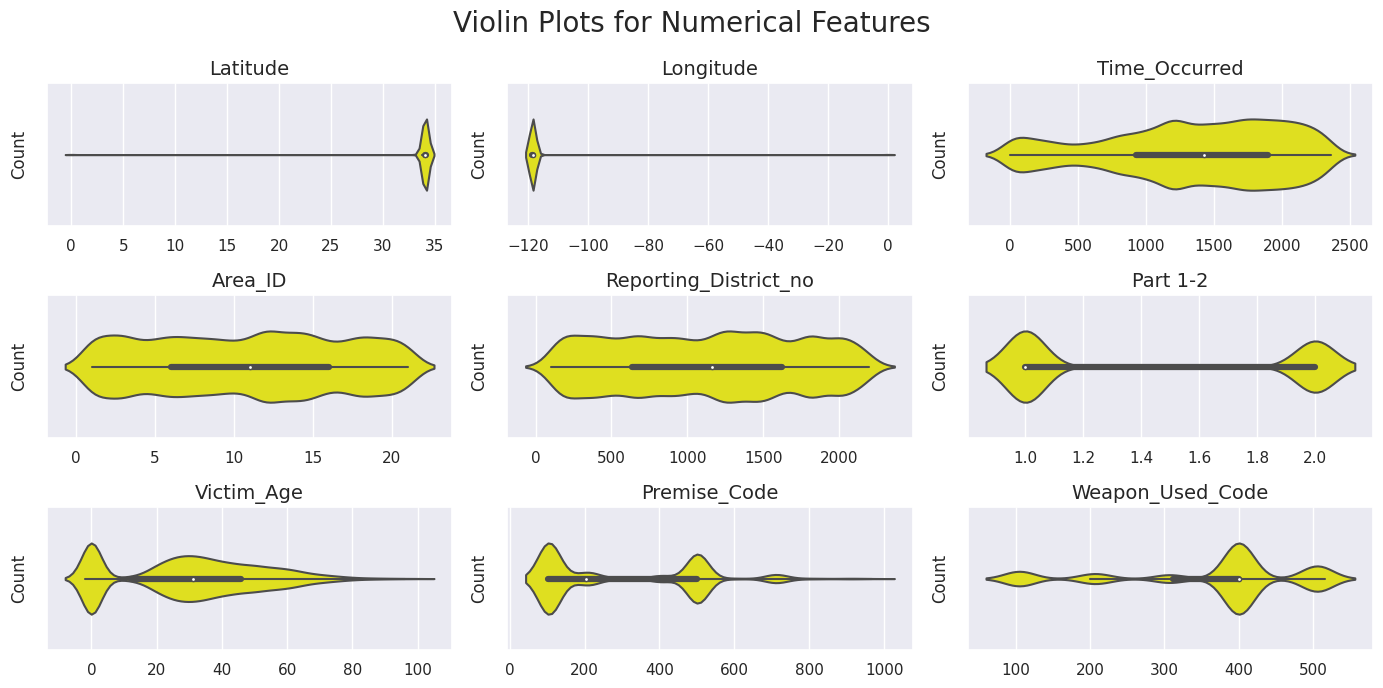

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(14, 7))

axes = axes.ravel()

for i, column in enumerate(Data_In):
    sns.violinplot(x=column, data=train, color='yellow', width=0.5, fliersize=5, ax=axes[i])
    axes[i].set_title(f'{column}', fontsize=14)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel('Count', fontsize=12)
plt.suptitle('Violin Plots for Numerical Features', fontsize=20)
plt.tight_layout()
plt.show()

**Plot 5 Inference**

**Latitude**:
The data is highly concentrated around the mid-30s, confirming the tight clustering seen in the box plot.
There is a small spread indicating low variance.

**Longitude**:
The data is tightly clustered around -118 to -120, with most data points concentrated in this range.
There are few outliers towards the right, but they are less significant compared to the main cluster.

**Time_Occurred**:
The data is fairly spread out with peaks around early and late hours of the day.
There is a bimodal distribution indicating two common times when incidents occur.

**Area_ID**:
The data is evenly distributed with slight peaks at multiple points, indicating certain areas have slightly more incidents.

**Reporting_District_no**:
The data is evenly distributed with a slight peak around 1200, suggesting more incidents are reported in this district.
There is no significant skewness.

**Part 1-2**:
The data is almost entirely concentrated around the value of 1, indicating a categorical distribution without much variation.

**Victim_Age**:
The data shows a multi-modal distribution with peaks around 20 and 40, indicating common victim ages.
There are some significant outliers around 100 years of age.

**Premise_Code**:
The data has several peaks, indicating certain premise codes are more common for incidents.
There is a wide range of premise codes, but most data is clustered around a few specific codes.

**Weapon_Used_Code**:
The data shows multiple peaks, indicating certain weapon codes are more frequently used.
There is a wide range of weapon codes, but with notable density around certain values.

**General Observations**:
Data Clustering: Latitude and Longitude are tightly clustered, suggesting geographical specificity.
Bimodal and Multimodal Distributions: Time_Occurred, Victim_Age, Premise_Code, and Weapon_Used_Code show multiple peaks indicating common values or categories.
Categorical Nature: Part 1-2 is highly concentrated around one value, confirming it is categorical.

# Data Preprocessing:

# Feature Engineering / Selection

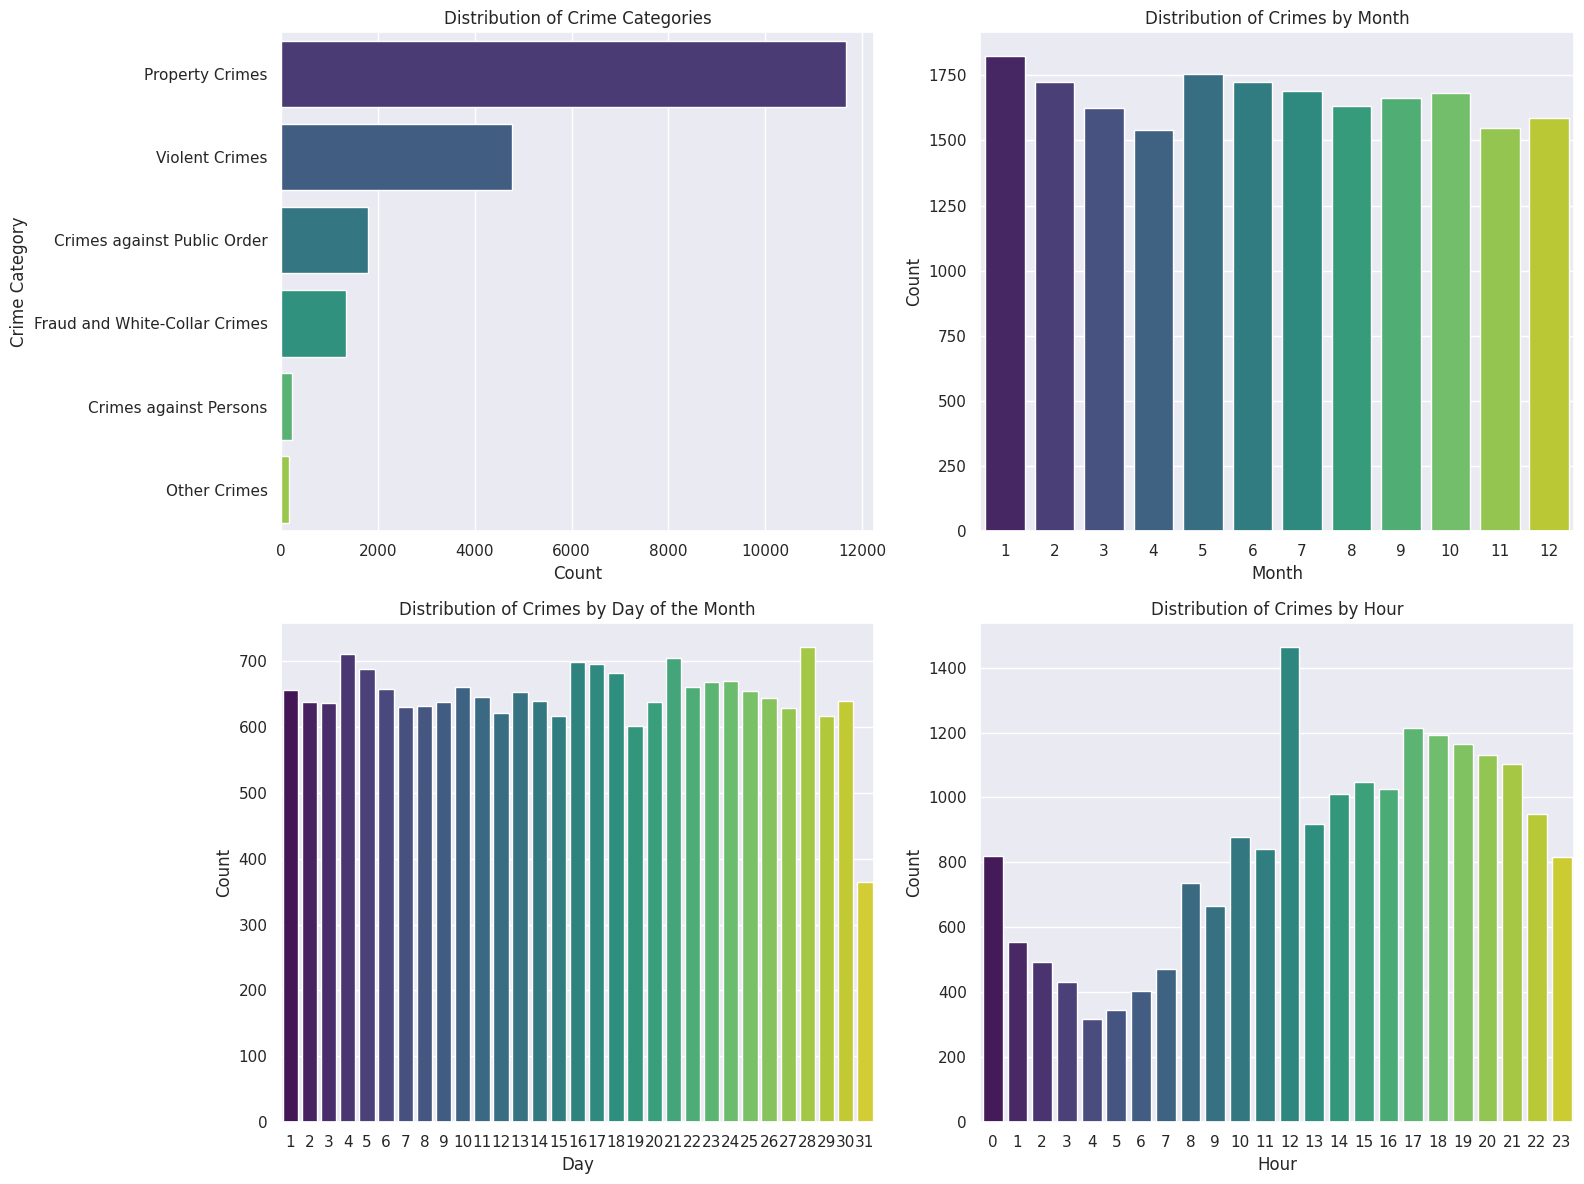

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
class DateConverter(BaseEstimator, TransformerMixin):
    def __init__(self, date_format):
        self.date_format = date_format

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format=self.date_format)
        X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format=self.date_format)
        return X

class DatePartExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Year_Reported'] = X['Date_Reported'].dt.year
        X['Month_Reported'] = X['Date_Reported'].dt.month
        X['Day_Reported'] = X['Date_Reported'].dt.day
        X['Hour_Occurred'] = X['Time_Occurred'].apply(lambda x: int(x // 100))
        return X
class DateConverter(BaseEstimator, TransformerMixin):
    def __init__(self, date_format):
        self.date_format = date_format

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format=self.date_format)
        X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format=self.date_format)
        return X

class DatePartExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Year_Reported'] = X['Date_Reported'].dt.year
        X['Month_Reported'] = X['Date_Reported'].dt.month
        X['Day_Reported'] = X['Date_Reported'].dt.day
        X['Hour_Occurred'] = X['Time_Occurred'].apply(lambda x: int(x // 100))
        return X
date_format = '%m/%d/%Y %I:%M:%S %p'

pipeline = Pipeline([
    ('date_converter', DateConverter(date_format=date_format)),
    ('date_part_extractor', DatePartExtractor())
])
train = pipeline.fit_transform(train)
test = pipeline.transform(test)
# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Distribution of crime categories
plt.subplot(2, 2, 1)
sns.countplot(y='Crime_Category', data=train, order=train['Crime_Category'].value_counts().index, palette='viridis')
plt.title('Distribution of Crime Categories')
plt.xlabel('Count')
plt.ylabel('Crime Category')

# Distribution of crimes by month
plt.subplot(2, 2, 2)
sns.countplot(x='Month_Reported', data=train, palette='viridis')
plt.title('Distribution of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Distribution of crimes by day of the month
plt.subplot(2, 2, 3)
sns.countplot(x='Day_Reported', data=train, palette='viridis')
plt.title('Distribution of Crimes by Day of the Month')
plt.xlabel('Day')
plt.ylabel('Count')

# Distribution of crimes by hour
plt.subplot(2, 2, 4)
sns.countplot(x='Hour_Occurred', data=train, palette='viridis')
plt.title('Distribution of Crimes by Hour')
plt.xlabel('Hour')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [14]:
class FillMissingCategorical(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value='Unknown'):
        self.fill_value = fill_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        categorical_cols = ['Cross_Street', 'Modus_Operandi', 'Victim_Sex', 'Victim_Descent', 'Premise_Description', 'Weapon_Description']
        for col in categorical_cols:
            X[col] = X[col].fillna(self.fill_value)
        return X

class FillMissingNumerical(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median = X['Weapon_Used_Code'].median()
        return self

    def transform(self, X):
        X = X.copy()
        X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(self.median)
        return X
# Create the pipeline for filling missing values
fill_missing_pipeline = Pipeline([
    ('fill_missing_categorical', FillMissingCategorical()),
    ('fill_missing_numerical', FillMissingNumerical())
])

# Apply the pipeline to the train and test datasets
train = fill_missing_pipeline.fit_transform(train)
test = fill_missing_pipeline.transform(test)

# Display the first few rows of the transformed data
print(train.head())
print(test.head())


                                   Location                     Cross_Street  \
0   4500    CARPENTER                    AV                          Unknown   
1           45TH                         ST  ALAMEDA                      ST   
2    600 E  MARTIN LUTHER KING JR        BL                          Unknown   
3  14900    ORO GRANDE                   ST                          Unknown   
4   7100 S  VERMONT                      AV                          Unknown   

   Latitude  Longitude Date_Reported Date_Occurred  Time_Occurred  Area_ID  \
0   34.1522  -118.3910    2020-03-09    2020-03-06         1800.0     15.0   
1   34.0028  -118.2391    2020-02-27    2020-02-27         1345.0     13.0   
2   34.0111  -118.2653    2020-08-21    2020-08-21          605.0     13.0   
3   34.2953  -118.4590    2020-11-08    2020-11-06         1800.0     19.0   
4   33.9787  -118.2918    2020-02-25    2020-02-25         1130.0     12.0   

     Area_Name  Reporting_District_no  ...     Pre

In [15]:
print(f"Count of NaN values in 'train_csv': {train.isna().sum().sum()} values")
print(f"Count of NaN values in 'test_csv': {test.isna().sum().sum()} values")

Count of NaN values in 'train_csv': 0 values
Count of NaN values in 'test_csv': 0 values


In [16]:
label_encoders = {}
categorical_columns = ['Location', 'Cross_Street', 'Area_Name', 'Modus_Operandi', 
                           'Victim_Sex', 'Victim_Descent', 'Premise_Description', 
                           'Weapon_Description', 'Status', 'Status_Description']


for col in categorical_columns:
    labelE = LabelEncoder()
    train[col] = labelE.fit_transform(train[col])
    
    # handle unseen labels in test data
    test[col] = test[col].map(lambda s: '<unknown>' if s not in labelE.classes_ else s)
    labelE.classes_ = np.append(labelE.classes_, '<unknown>')
    test[col] = labelE.transform(test[col])
    
    # store the label encoder
    label_encoders[col] = labelE

In [17]:
labelE_crime_category = LabelEncoder()
train['Crime_Category'] = labelE_crime_category.fit_transform(train['Crime_Category'])

In [18]:
scaler = StandardScaler()
numerical_columns = ['Latitude', 'Longitude', 'Time_Occurred', 'Area_ID', 
                     'Reporting_District_no', 'Part 1-2', 'Victim_Age', 
                     'Premise_Code', 'Weapon_Used_Code']

train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

# Model Training

In [19]:
X = train.drop(columns=['Crime_Category', 'Date_Reported', 'Date_Occurred'])
y = train['Crime_Category']

# prepare test data (assuming
X_test = test.drop(columns=['Date_Reported', 'Date_Occurred'])

# split the training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
metrics = pd.DataFrame(columns = ['Accuracy', 'F1_Score'])

(16000, 23) (4000, 23) (16000,) (4000,)


# Baseline : Dummy Classifier

In [20]:
dummy_clf = DummyClassifier(strategy="most_frequent")


dummy_clf.fit(X_train, y_train)


dummy_pred = dummy_clf.predict(X_val)


metrics = pd.DataFrame(columns=['Accuracy', 'F1_Score'])


accuracy = accuracy_score(y_val, dummy_pred)
f1 = f1_score(y_val, dummy_pred, average='macro')


metrics.loc['Dummy Classifier'] = [accuracy, f1]


error_rate = 1 - accuracy


print('='*25 + f' Model : {metrics.index[-1]} ' + '='*25 + '\n')
print(classification_report(y_val, dummy_pred))

print("\nAccuracy (Validation Data) : {}%".format(round(metrics.loc[metrics.index[-1]].Accuracy*100, 3)))
print("Macro F1-Score (Validation Data) : {}".format(round(metrics.loc[metrics.index[-1]].F1_Score, 3)))
print("Error Rate (Validation Data) : {}".format(round(error_rate, 3)))


========================= Model : Dummy Classifier =========================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00       374
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00        35
           4       0.58      1.00      0.73      2303
           5       0.00      0.00      0.00       989

    accuracy                           0.58      4000
   macro avg       0.10      0.17      0.12      4000
weighted avg       0.33      0.58      0.42      4000


Accuracy (Validation Data) : 57.575%
Macro F1-Score (Validation Data) : 0.122
Error Rate (Validation Data) : 0.424


# Model-1 : Logistic Regression

In [21]:
# param_grid = {
#     'poly_features__degree': [1, 2, 3], 
#     'log_reg__C': [0.01, 0.1, 1, 10, 100],
#     'log_reg__penalty': ['l1', 'l2'],
#     'log_reg__solver': ['liblinear', 'saga'] 
# }


# pipeline = Pipeline([
#     ('poly_features', PolynomialFeatures()),
#     ('log_reg', LogisticRegression(max_iter=10000))
# ])


# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_

In [22]:
# Best parameters found
best_params = {
    'poly_features__degree': 2,
    'log_reg__C': 10,
    'log_reg__penalty': 'l2',
    'log_reg__solver': 'liblinear'
}

LR = LogisticRegression(C=best_params['log_reg__C'], 
                        penalty=best_params['log_reg__penalty'], 
                        solver=best_params['log_reg__solver'], 
                        max_iter=10000)

LR.fit(X_train, y_train)

LR_pred = LR.predict(X_val)

accuracy = accuracy_score(y_val, LR_pred)
f1 = f1_score(y_val, LR_pred, average='macro')


metrics.loc['Logistic Regression'] = [accuracy, f1]


error_rate = 1 - accuracy


print('='*25 + f' Model : Logistic Regression ' + '='*25 + '\n')
print(classification_report(y_val, LR_pred))


print("\nAccuracy (Validation Data) : {}%".format(round(metrics.loc['Logistic Regression'].Accuracy * 100, 3)))
print("Macro F1-Score (Validation Data) : {}".format(round(metrics.loc['Logistic Regression'].F1_Score, 3)))
print("Error Rate (Validation Data) : {}".format(round(error_rate, 3)))


========================= Model : Logistic Regression =========================

              precision    recall  f1-score   support

           0       0.33      0.06      0.11        32
           1       0.73      0.05      0.10       374
           2       0.59      0.69      0.64       267
           3       0.00      0.00      0.00        35
           4       0.85      0.92      0.88      2303
           5       0.67      0.78      0.72       989

    accuracy                           0.78      4000
   macro avg       0.53      0.42      0.41      4000
weighted avg       0.77      0.78      0.74      4000


Accuracy (Validation Data) : 77.675%
Macro F1-Score (Validation Data) : 0.408
Error Rate (Validation Data) : 0.223


# Model-2 : SVC

In [23]:
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
# import numpy as np


# param_grid = {
#     'svc__C': [0.1, 1, 10],  # Regularization parameter
#     'svc__kernel': ['linear', 'rbf'],  # Kernel type
#     'svc__gamma': ['scale', 'auto']  # Kernel coefficient
# }

# pipeline = Pipeline([
#     ('svc', SVC())
# ])

# grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_

# best_model_pred = best_model.predict(X_val)

In [24]:
svc_params = {
    'imputer': SimpleImputer(strategy='mean'),
    'pca__n_components': 5,
    'classifier': SVC(C=10, kernel='rbf', gamma='scale', probability=True)
}

svc_model = Pipeline([
    ('imputer', svc_params['imputer']),
    ('pca', PCA(n_components=svc_params['pca__n_components'])),
    ('classifier', svc_params['classifier'])
])

svc_model.fit(X_train, y_train)


svc_pred = svc_model.predict(X_val)


accuracy = accuracy_score(y_val, svc_pred)
f1 = f1_score(y_val, svc_pred, average='macro')


metrics.loc['SVM'] = [accuracy, f1]


error_rate = 1 - accuracy

print('='*25 + ' Model : SVC (Manual Tuning) ' + '='*25 + '\n')
print(classification_report(y_val, svc_pred))

print("\nAccuracy (Validation Data) : {}%".format(round(metrics.loc['SVM'].Accuracy * 100, 3)))
print("Macro F1-Score (Validation Data) : {}".format(round(metrics.loc['SVM'].F1_Score, 3)))
print("Error Rate (Validation Data) : {}".format(round(error_rate, 3)))


========================= Model : SVC (Manual Tuning) =========================

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00       374
           2       0.00      0.00      0.00       267
           3       0.00      0.00      0.00        35
           4       0.76      0.93      0.84      2303
           5       0.59      0.71      0.64       989

    accuracy                           0.71      4000
   macro avg       0.22      0.27      0.25      4000
weighted avg       0.58      0.71      0.64      4000


Accuracy (Validation Data) : 70.925%
Macro F1-Score (Validation Data) : 0.247
Error Rate (Validation Data) : 0.291


# Model-3 : KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
params=[{'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50,100]}]
from sklearn.model_selection import GridSearchCV
gs=GridSearchCV(KNeighborsClassifier(),params,cv=10,scoring='neg_mean_squared_error')
gs.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 50,
                                          100]}],
             scoring='neg_mean_squared_error')

In [26]:
print(f'Best K for KNN : {gs.best_estimator_}')
KNN_pred = gs.predict(X_val)

print('='*25 + f' Model : KNN ' + '='*25 + '\n')
print(classification_report(y_val, KNN_pred))

accuracy = accuracy_score(y_val, KNN_pred)
f1 = f1_score(y_val, KNN_pred, average='macro')

metrics.loc['KNN'] = [accuracy, f1]


error_rate = 1 - accuracy


print("\nAccuracy (Validation Data) : {}%".format(round(metrics.loc['KNN'].Accuracy * 100, 3)))
print("Macro F1-Score (Validation Data) : {}".format(round(metrics.loc['KNN'].F1_Score, 3)))
print("Error Rate (Validation Data) : {}".format(round(error_rate, 3)))


Best K for KNN : KNeighborsClassifier(n_neighbors=18)
========================= Model : KNN =========================

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        32
           1       0.33      0.10      0.15       374
           2       0.53      0.47      0.50       267
           3       0.00      0.00      0.00        35
           4       0.79      0.91      0.85      2303
           5       0.67      0.67      0.67       989

    accuracy                           0.73      4000
   macro avg       0.55      0.36      0.37      4000
weighted avg       0.70      0.73      0.70      4000


Accuracy (Validation Data) : 73.3%
Macro F1-Score (Validation Data) : 0.372
Error Rate (Validation Data) : 0.267


# Model-4 XGB

In [27]:
# xgb_refined_params = {
#     'n_estimators': [90, 100, 110],
#     'learning_rate': [0.05, 0.1, 0.15],
#     'max_depth': [6, 7, 8],
#     'min_child_weight': [4, 5, 6],
#     'subsample': [0.9, 1.0],
#     'colsample_bytree': [0.5, 0.6, 0.7]
# }

# grid_search_xgb_refined = RandomizedSearchCV(estimator=XGBClassifier(random_state=42), param_distributions=xgb_refined_params, cv=3, n_jobs=-1, verbose=3, random_state=42, n_iter=100)
# grid_search_xgb_refined.fit(X_train, y_train)
# best_xgb_refined_model = grid_search_xgb_refined.best_estimator_

In [28]:
best_xgb_params = {
    'colsample_bytree': 0.5,
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_weight': 4,
    'n_estimators': 90,
    'objective': 'multi:softprob',
    'random_state': 42
}

best_xgb_model = XGBClassifier(**best_xgb_params)

best_xgb_model.fit(X_train, y_train)

XGB_pred = best_xgb_model.predict(X_val)

print('='*25 + ' Model : XGB ' + '='*25 + '\n')
print(classification_report(y_val, XGB_pred))

accuracy = accuracy_score(y_val, XGB_pred)
f1 = f1_score(y_val, XGB_pred, average='macro')

metrics.loc['XGB'] = [accuracy, f1]


error_rate = 1 - accuracy

print("\nAccuracy (Validation Data) : {}%".format(round(metrics.loc['XGB'].Accuracy * 100, 3)))
print("Macro F1-Score (Validation Data) : {}".format(round(metrics.loc['XGB'].F1_Score, 3)))
print("Error Rate (Validation Data) : {}".format(round(error_rate, 3)))

========================= Model : XGB =========================

              precision    recall  f1-score   support

           0       0.59      0.53      0.56        32
           1       0.79      0.77      0.78       374
           2       0.95      0.86      0.90       267
           3       0.29      0.06      0.10        35
           4       0.97      0.96      0.96      2303
           5       0.87      0.94      0.91       989

    accuracy                           0.92      4000
   macro avg       0.74      0.69      0.70      4000
weighted avg       0.92      0.92      0.92      4000


Accuracy (Validation Data) : 92.025%
Macro F1-Score (Validation Data) : 0.701
Error Rate (Validation Data) : 0.08


# Comparison of Models

In [29]:
metrics

,Accuracy,F1_Score
Dummy Classifier,0.57575,0.121794
Logistic Regression,0.77675,0.407739
SVM,0.70925,0.246571
KNN,0.73300,0.371856
XGB,0.92025,0.700962


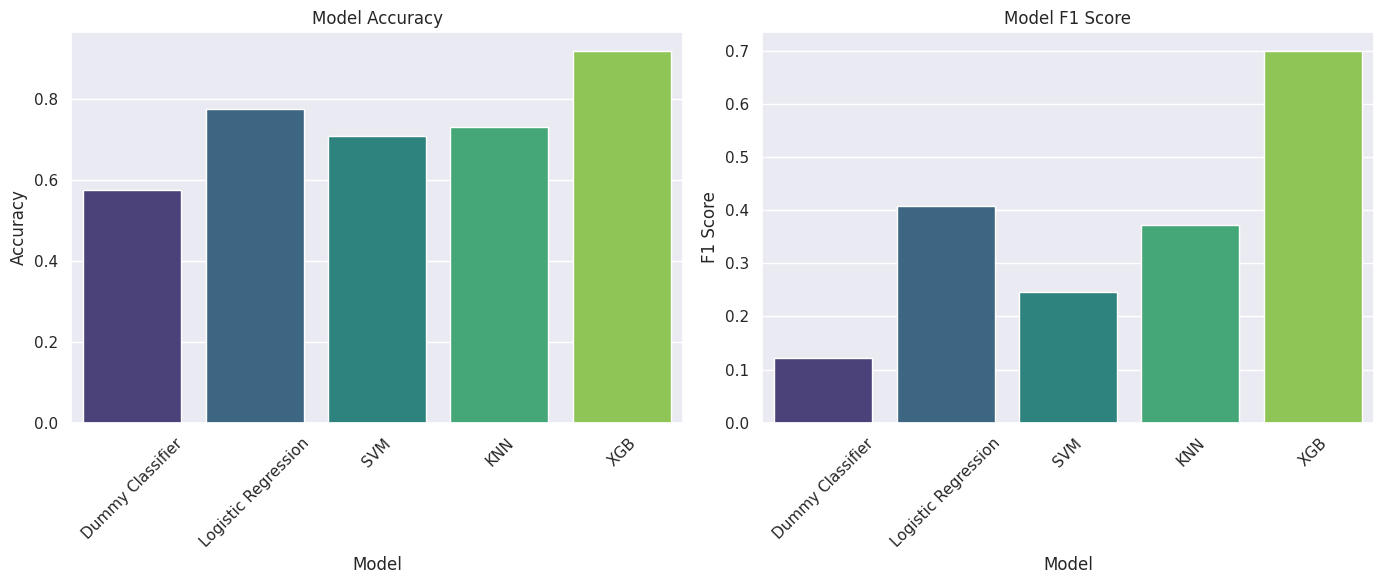

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(x=metrics.index, y=metrics['Accuracy'], ax=ax[0], palette='viridis')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(x=metrics.index, y=metrics['F1_Score'], ax=ax[1], palette='viridis')
ax[1].set_title('Model F1 Score')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 Score')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


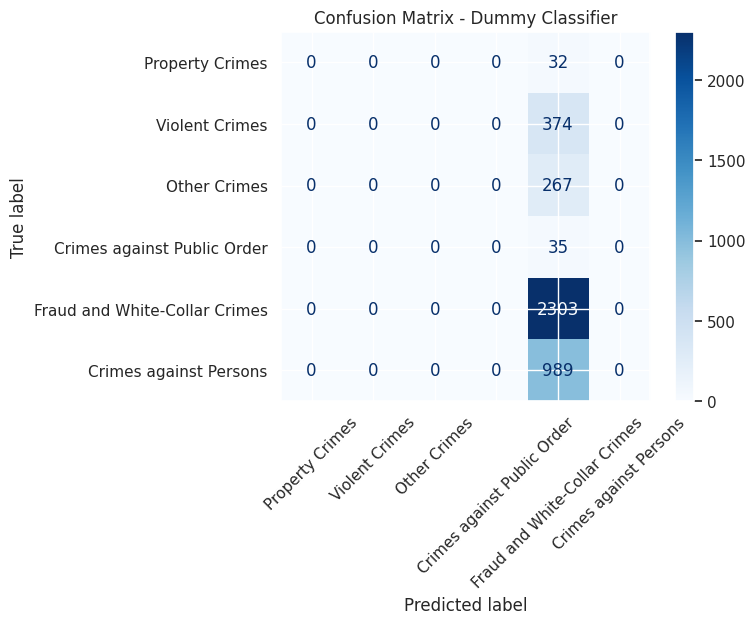

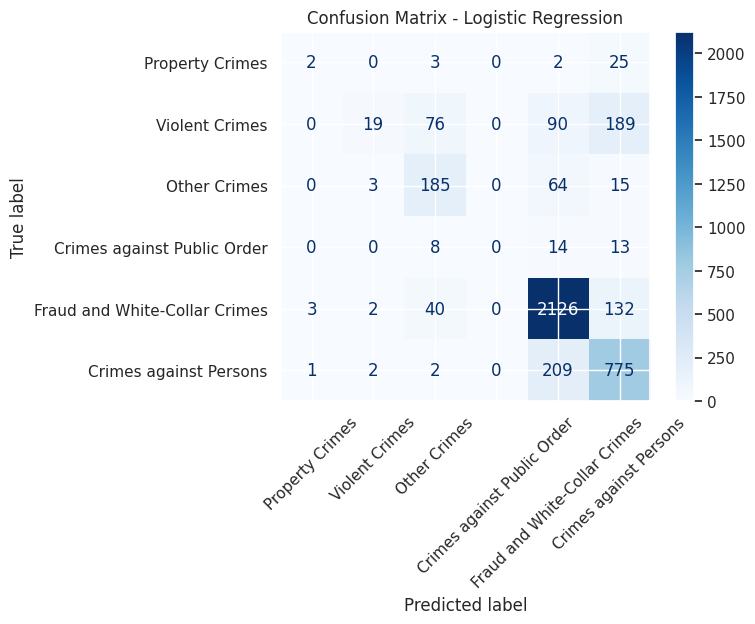

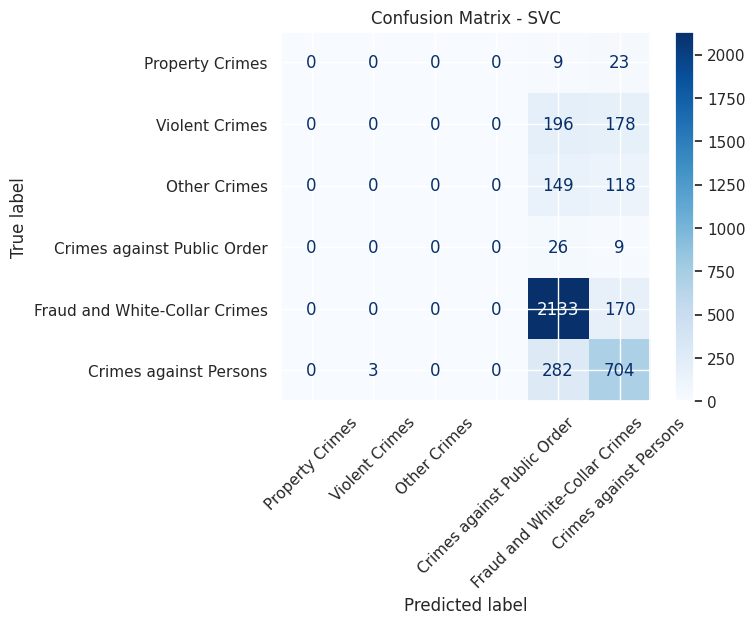

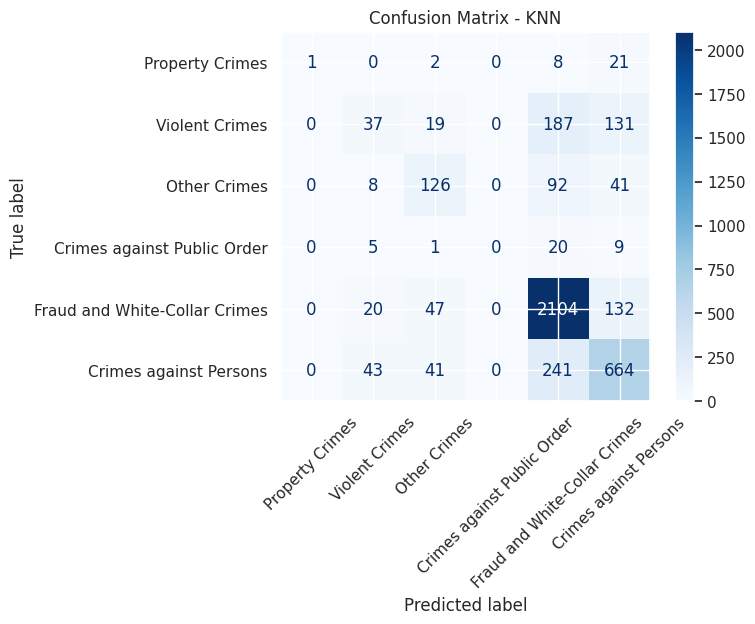

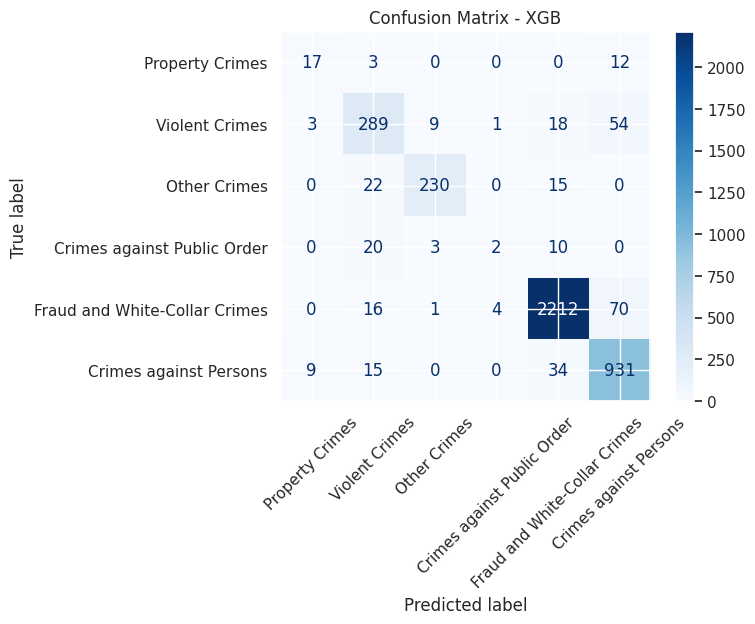

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, model_name, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45)  
    plt.show()


class_names = label.unique()  

# Plot confusion matrix for each model
plot_confusion_matrix(y_val, dummy_pred, 'Dummy Classifier', class_names)
plot_confusion_matrix(y_val, LR_pred, 'Logistic Regression', class_names)
plot_confusion_matrix(y_val, svc_pred, 'SVC', class_names)
plot_confusion_matrix(y_val, KNN_pred, 'KNN', class_names)
plot_confusion_matrix(y_val, XGB_pred, 'XGB', class_names)





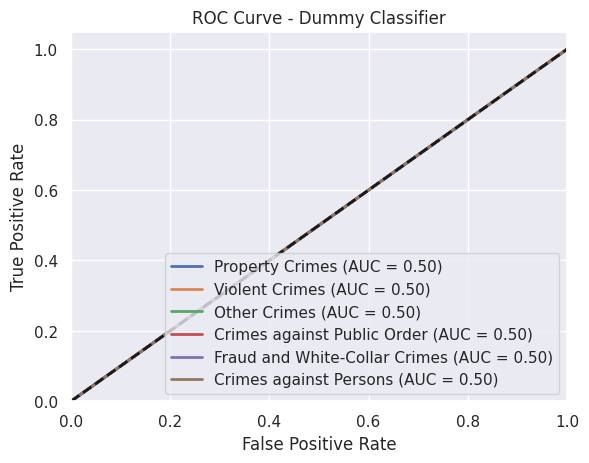

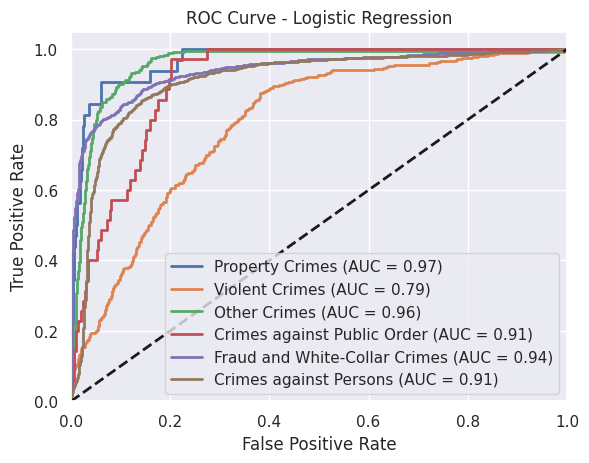

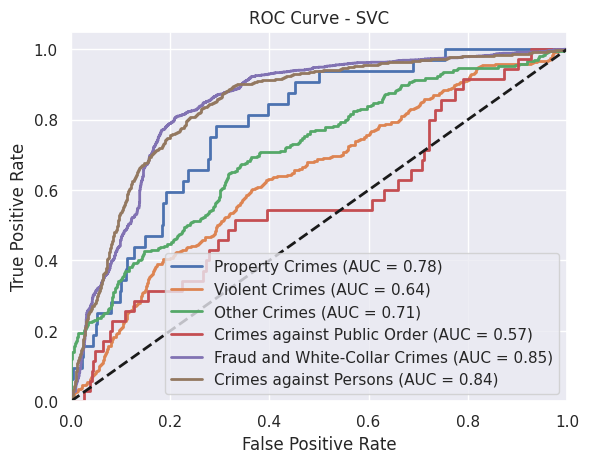

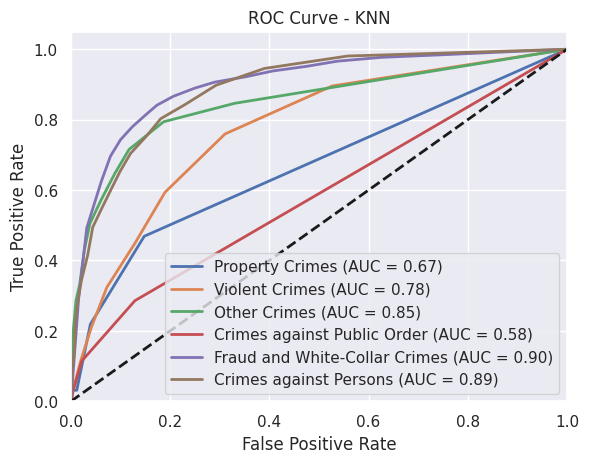

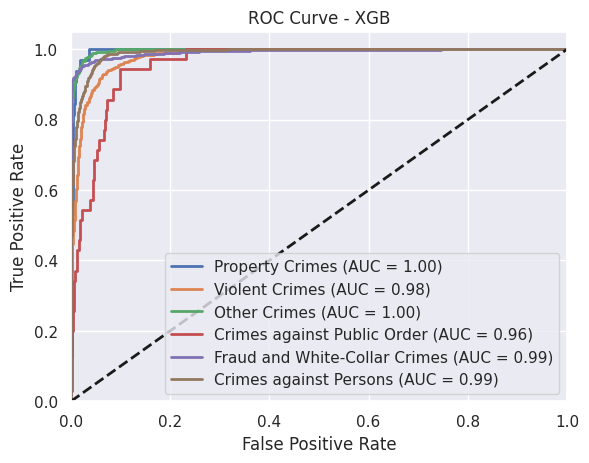

In [32]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np


class_names = label.unique()
y_val_binarized = label_binarize(y_val, classes=[0, 1, 2,3,4,5,]) 
n_classes = y_val_binarized.shape[1]

# Function to plot ROC curve
def plot_roc_curve(y_true_binarized, y_score, model_name):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

# Predict probabilities for ROC
dummy_proba = np.zeros_like(y_val_binarized)  # Dummy model doesn't provide probabilities
logistic_proba = LR.predict_proba(X_val)
svc_proba = svc_model.predict_proba(X_val)
knn_proba = gs.predict_proba(X_val)
xgb_proba = best_xgb_model.predict_proba(X_val)

# Plot ROC for each model
plot_roc_curve(y_val_binarized, dummy_proba, 'Dummy Classifier')
plot_roc_curve(y_val_binarized, logistic_proba, 'Logistic Regression')
plot_roc_curve(y_val_binarized, svc_proba, 'SVC')
plot_roc_curve(y_val_binarized, knn_proba, 'KNN')
plot_roc_curve(y_val_binarized, xgb_proba, 'XGB')



# Conclusion:
****XGBoost (XGB)**** demonstrates superior performance among the models, with high AUC values and well-distributed confusion matrix results.

****Logistic Regression and SVC**** also perform reasonably well, especially for certain crime categories.

****KNN**** is less effective in this context, with notable misclassifications.

****Dummy Classifier**** is used for baseline comparison and shows poor performance, as expected.

Overall, ****XGBoost**** appears to be the most effective model for classifying the different types of crimes, followed by Logistic Regression and SVC.

# Submission

In [33]:
classes = labelE_crime_category.classes_
print("Encoded classes:", classes)
mappings = dict(zip(range(len(labelE_crime_category.classes_)), labelE_crime_category.classes_))
print(mappings)

Encoded classes: ['Crimes against Persons' 'Crimes against Public Order'
 'Fraud and White-Collar Crimes' 'Other Crimes' 'Property Crimes'
 'Violent Crimes']
{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [34]:
y_pre=best_xgb_model.predict(X_test)
y_pred=labelE_crime_category.inverse_transform(y_pre)
y_pred

array(['Violent Crimes', 'Property Crimes', 'Crimes against Public Order',
       ..., 'Violent Crimes', 'Violent Crimes', 'Property Crimes'],
      dtype=object)

In [35]:
submission = pd.DataFrame({"ID": np.arange(1,5001), 
                           "Crime_Category": y_pred,
                          }
                         ) 

submission.to_csv('submission.csv',index=False)